# Visualisierung und Auswertung von Omniscope- und Picoscopedaten mit Python
## Contents
1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [PicoScope Data](#PicoScope-Data)
4. [Omnicscope v1 Data](#Omnicscope-v1-Data)

## Introduction
This notebook is used to analyse current data.

## Setup
In the following, code for the setup is executed.
This includes the import of all necessary libraries and the definition of all necessary functions.

In [1]:
import os

import sys
import logging
import numpy as np
import pandas as pd
import IPython.display as ipd

import librosa
import librosa.display

Determine if the code is executed in a notebook or not.

In [2]:
def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

currentdir = os.path.dirname(os.path.realpath("__file__"))
parentdir = os.path.dirname(currentdir)
if isnotebook():
    sys.path.append(parentdir)
    sys.path.insert(0, parentdir)
else:
    sys.path.insert(0, currentdir)
    print(currentdir)

Logging is important!

In [3]:
os.makedirs("logs", exist_ok=True)

logging.root.handlers = []
logging.basicConfig(
    level=logging.INFO,
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler("logs/example_file_handler.log")
    ]
)
logger = logging.getLogger(__name__)

Import `anAIlysis` library.
This library is used to analyse diffetent types of data. It also include file handlers for different file types of AI developed products.
<br>
[**anAIlysis Documentation**](https://ai-gruppe.github.io/ai_internal_anAIlysis-rg_sw/)

In [4]:
from anAIlysis import ESA
from anAIlysis import signal_processing as DSP
# from anAIlysis import plotting as eplt
# from anAIlysis import signal_analysis as SA
from anAIlysis import get_samplerate as GSR
from anAIlysis import file_handler as fh

# Set random seed for reproducibility
np.random.seed(seed=42)

There are several different backend for plotting in Matplotlib.
- `inline` is used for Jupyter Notebooks (Image in Notebook)
- `widget` is used for Jupyter Lab (Interactive Plot in Notebook)
- `WebAgg` is used for ssh connections without display (Interactive Plot in Browser)
- `TkAgg` is used for local plotting (Interactive Plot in Window)
- `Qt5Agg` is used for local plotting (Interactive Plot in Window)

In [5]:
# Use WebAgg if no display is connected (e.g. ssh) and not running as notebook
import matplotlib
if (os.name == 'posix' and "DISPLAY" not in os.environ) and not isnotebook():
    matplotlib.use('WebAgg')
elif isnotebook():
    try:
        get_ipython().run_line_magic('matplotlib', 'widget')
    except ModuleNotFoundError:
        get_ipython().run_line_magic('matplotlib', 'inline')

# Return used Matplotlib backend
logger.info(f"Matplotlib backend: {matplotlib.get_backend()}")

import matplotlib.pyplot as plt

INFO:__main__:Matplotlib backend: module://ipympl.backend_nbagg


## PicoScope Data
### Load the data

In [6]:
filepath = "data/Testmessung_fuer_Sazan_2023-01-24.csv"

if isnotebook():
    filepath = os.path.join(parentdir, filepath)

# Load data with file handler. It also includes error handling
df, meta = fh.get_pico_dataframe(filepath, german=True)

# Main function of file handler for loading picoscope data
# df = pd.read_csv(data_path, index_col=0, header=[0, 1], sep=';', decimal=",")

### Apply Calibration
$$ U_{1,2,3} = U_{A,C,E} \cdot d $$
$$ I_{1,2,3} = (U_{A,C,E} - U_{B,D,F}) \cdot d \cdot R^{-1} $$
'd' is the damping factor and 'R' is the resistance of the shunt resistor.
The current is calculated with the voltage difference between the shunt resistor and the voltage measurement.

In [7]:
resistance = 1
damping = 10

u_1 = df["Kanal A"] * damping
u_2 = df["Kanal C"] * damping
u_3 = df["Kanal E"] * damping

i_1 = (df["Kanal A"] - df["Kanal B"]) * damping / resistance
i_2 = (df["Kanal C"] - df["Kanal D"]) * damping / resistance
i_3 = (df["Kanal E"] - df["Kanal F"]) * damping / resistance

df_cal = pd.DataFrame({
    "U_1": u_1,
    "U_2": u_2,
    "U_3": u_3,
    "I_1": i_1,
    "I_2": i_2,
    "I_3": i_3,
})

### Plot the data

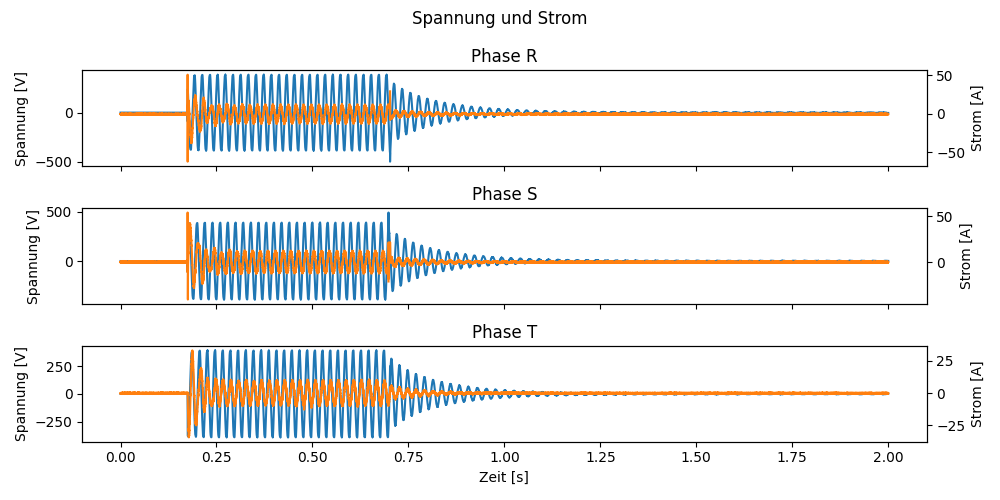

In [8]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 5), sharex=True)

phase_description = ["R", "S", "T"]

for i, ax in enumerate(axs):
    # Color cycle. Important for twin axes
    color_cycle = ax._get_lines.prop_cycler
    
    ax.plot(df_cal.index, df_cal[f"U_{i+1}"], label=f"U_{i+1}")
    ax.set_ylabel("Spannung [V]")
    ax1 = ax.twinx()
    ax1.plot(df_cal.index, df_cal[f"I_{i+1}"], label=f"I_{i+1}", color=next(color_cycle)["color"])
    ax1.set_ylabel("Strom [A]")
    ax.set_title(f"Phase {phase_description[i]}")

ax.set_xlabel("Zeit [s]")
fig.suptitle('Spannung und Strom')
fig.tight_layout()

### Analyse the data
#### RMS

In [9]:
t_start = 0.3
t_end = 0.6
df_cal_tmp = df_cal[(df_cal.index > t_start) & (df_cal.index < t_end)]

for i in range(3):
    u_rms = DSP.rms(df_cal_tmp[f"U_{i+1}"])
    i_rms = DSP.rms(df_cal_tmp[f"I_{i+1}"])
    logger.info(f"Phase {phase_description[i]}: U_rms = {u_rms:.2f} V, I_rms = {i_rms:.2f} A")

INFO:__main__:Phase R: U_rms = 275.57 V, I_rms = 8.03 A
INFO:__main__:Phase S: U_rms = 277.71 V, I_rms = 8.35 A
INFO:__main__:Phase T: U_rms = 278.28 V, I_rms = 6.55 A
INFO:__main__:Phase S: U_rms = 277.71 V, I_rms = 8.35 A
INFO:__main__:Phase T: U_rms = 278.28 V, I_rms = 6.55 A


#### Windowed RMS

In [10]:
window_size = 0.05 # in seconds
fs = meta["Rate"]
ws_samples = int(window_size * fs)

n_frames = int(len(df_cal.index) / ws_samples)

df_result = pd.DataFrame()

for frame in range(n_frames):
    t_start = frame * window_size
    t_end = (frame + 1) * window_size
    for i in range(3):
        df_cal_tmp = df_cal[(df_cal.index > t_start) & (df_cal.index < t_end)]
        df_result.loc[t_end, f"U_rms_{i+1}"] = DSP.rms(df_cal_tmp[f"U_{i+1}"])
        df_result.loc[t_end, f"I_rms_{i+1}"] = DSP.rms(df_cal_tmp[f"I_{i+1}"])

#### Plot RMS Results

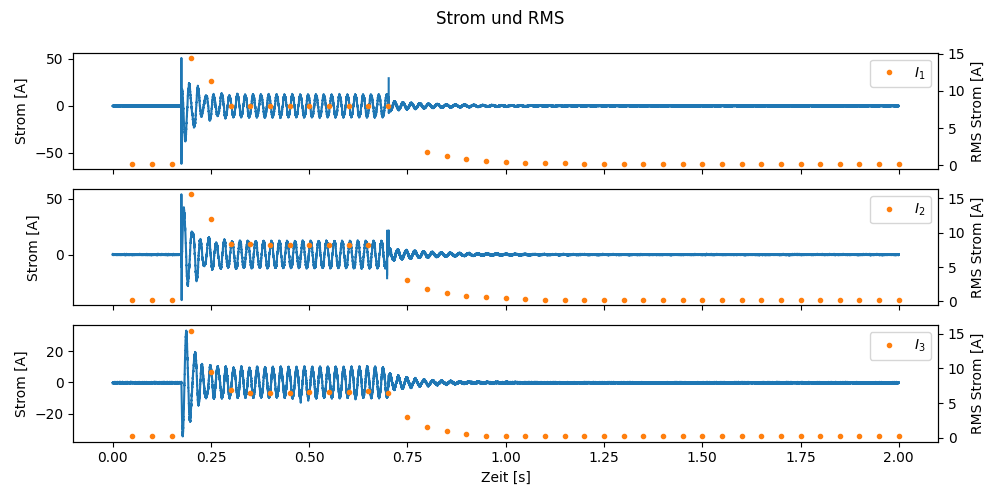

In [11]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 5), sharex=True)

phase_description = ["R", "S", "T"]

for i, ax in enumerate(axs):
    color_cycle = ax._get_lines.prop_cycler
    ax.plot(df_cal.index, df_cal[f"I_{i+1}"], label=f"I_{i+1}")
    ax.set_ylabel("Strom [A]")
    ax1 = ax.twinx()

    df_result.plot(y=f"I_rms_{i+1}", ax=ax1, label=r'$I_{{{0}}}$'.format(i+1), color=next(color_cycle)["color"], style=".")
    ax1.set_ylabel("RMS Strom [A]")

ax.set_xlabel("Zeit [s]")
fig.suptitle('Strom und RMS')
fig.tight_layout()

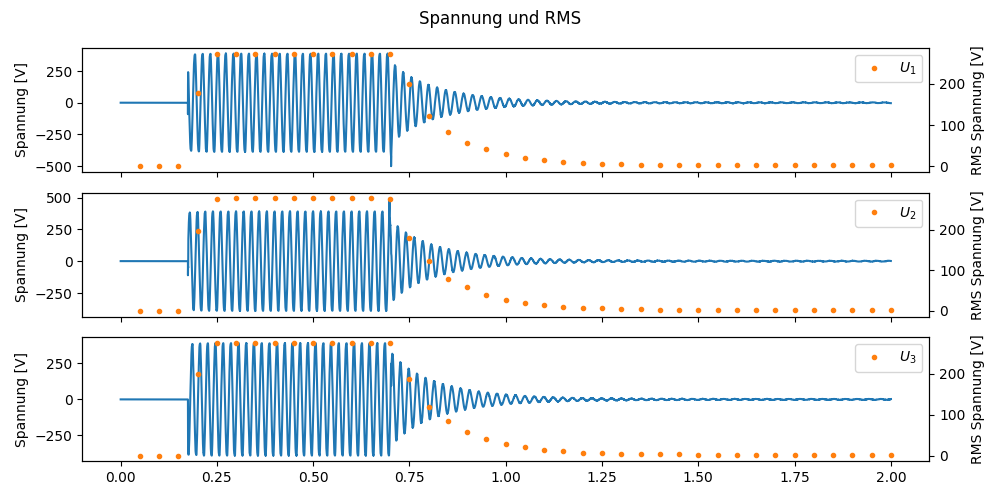

In [12]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 5), sharex=True)

phase_description = ["R", "S", "T"]

for i, ax in enumerate(axs):
    color_cycle = ax._get_lines.prop_cycler
    ax.plot(df_cal.index, df_cal[f"U_{i+1}"], label=f"U_{i+1}")
    ax.set_ylabel("Spannung [V]")
    ax1 = ax.twinx()

    df_result.plot(y=f"U_rms_{i+1}", ax=ax1, label=r'$U_{{{0}}}$'.format(i+1), color=next(color_cycle)["color"], style=".")
    ax1.set_ylabel("RMS Spannung [V]")

fig.suptitle('Spannung und RMS')
fig.tight_layout()

## Omnicscope v1 Data
### Load the data

In [13]:
filepath = "./data/scopedata-1_1"

if isnotebook():
    filepath = os.path.join(parentdir, filepath)

data, metadata = fh.get_omni_v1_data(filepath, path_calib_data=None)

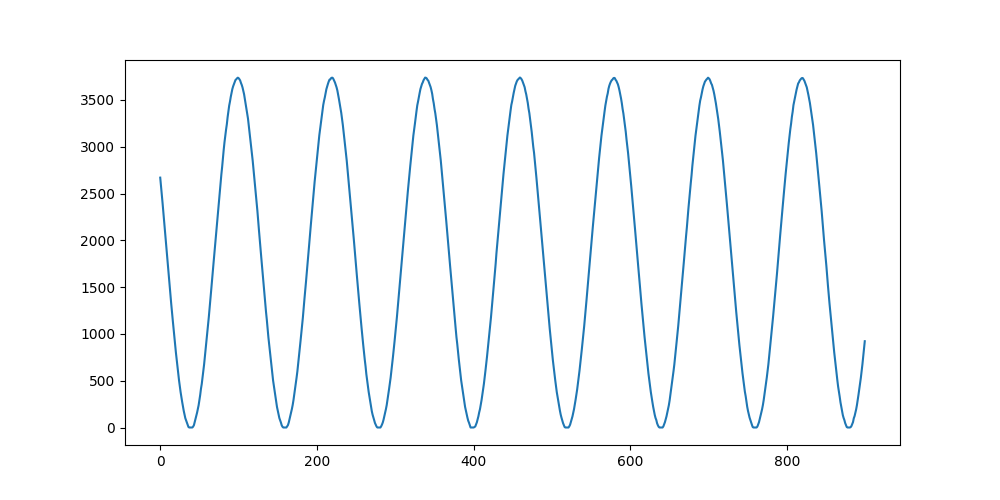

In [14]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 5), sharex=True)

ax.plot(data[100:1000], label="CH1")

In [15]:
if not isnotebook():
    plt.show()